## Topic modeling and flair prediction from the banned r/proED/ subreddit (Part 3)

Part 3 of this project examines whether ML models could predict a flair given a post using the dataset scraped and saved in Part 1.

### Import libraries and dataset

In [ ]:
!python -m spacy download en_core_web_md | grep -v 'already satisfied'

In [1]:
import numpy as np
import pandas as pd
import re

import spacy
nlp = spacy.load("en_core_web_md")

#this funstion suppresses sklearn deprecation warnings 
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.nn import functional as F

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import metrics
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

import seaborn as sns

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Import the dataset

In [3]:
df = pd.read_csv('/content/drive/MyDrive/Colab_Notebooks/proED_full_dataset_clean_sm.csv')
df = df.iloc[:, 1:]
df.head()

,Text,Flair
0,trying first 2day fast plan use post motivatio...,none
1,body issues mom edit cant flair mobileim frust...,rant/rave
2,whats amount weight youve lost shortest period...,discussion
3,day 8 restriction want encouragement please ♡ ...,rant/rave
4,eat much httpwwwthebookoflifeorgwhyweeattoomuch,discussion


To simplify the task, I will focus on 5 out of the 10 flairs. I will also remove rows with NaN values and values that are too long for SpaCy to handle.

In [4]:
flairs_selected = ['rant/rave', 'discussion', 'help', 'goal', 'thinspo']
df = df[df['Flair'].isin(flairs_selected)]

df = df[df.isnull().any(axis=1) == False]
df = df.loc[df['Text'].map(len) <= 100000]

### splitting into train and test data

In [5]:
X = df['Text']
y = df['Flair']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)
print(len(X_train), len(X_test))

37973 9494


### comparing various ML models with sci-kit learn
The problem that I am dealing with in this project is multi-class text classification; given a string, a model must predict which class/category the text belongs to. <br>
I will compare several of the algorithms suitable for the task, all of which are readily available in the scikit-learn library. <br>
I adapted the code to compare different algorithms from [this page](https://towardsdatascience.com/multi-class-text-classification-with-scikit-learn-12f1e60e0a9f).

In [41]:
tfidf = TfidfVectorizer()
features = tfidf.fit_transform(X)
labels = y

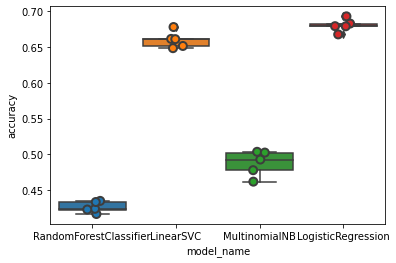

In [42]:
models = [RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
          LinearSVC(),
          MultinomialNB(),
          LogisticRegression(random_state=0)]
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))

entries = []
for model in models:
  model_name = model.__class__.__name__
  accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
  for fold_idx, accuracy in enumerate(accuracies):
    entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)

In [43]:
cv_df.groupby('model_name').accuracy.mean()

model_name
LinearSVC                 0.660248
LogisticRegression        0.680536
MultinomialNB             0.487666
RandomForestClassifier    0.426212
Name: accuracy, dtype: float64

Overall, accuracy is not that great, but it's clear that LinearSVC and logistic regression performed much better than the other two models.

### single-layer neural network

The code for generating and training a single-layer NN model was adapted for the materials in Udemy's [PyTorch for Deep Learning with Python Bootcamp](https://www.udemy.com/course/pytorch-for-deep-learning-with-python-bootcamp/). <br>
Below is the function that vectorizes each word in a text, using SpaCy's pre-trained word embedding model. The returned value is the average vector converted to a tensor. 

In [6]:
def vectorize(text):
    text = nlp(text)
    vec = [word.vector for word in text]
    return torch.tensor(sum(vec) / len(vec))

Create tensors of the independent variable X. This code will take some time to finish running...

In [30]:
X_train_tensor = torch.stack([vectorize(text) for text in X_train])
X_test_tensor = torch.stack([vectorize(text) for text in X_test])

Next, create a function that maps each flair to a number. Change the values of the dependent variable y using this function, and convert them to tensors.

In [7]:
mapping_dict = {}
for i, f in enumerate(list(set(df['Flair']))):
    mapping_dict[f] = i

y_train_tensor = torch.LongTensor(y_train.map(mapping_dict).values)
y_test_tensor = torch.LongTensor(y_test.map(mapping_dict).values)

Save the tensors

In [21]:
torch.save(X_train_tensor, 'X_train.pt')
torch.save(X_test_tensor, 'X_test.pt')
torch.save(y_train_tensor, 'y_train.pt')
torch.save(y_test_tensor, 'y_test.pt')

Create a single neural network model with no hidden layers. The model consists of the following functions: <br>
* `__init__`: This is where you define layers that make up the model
* `forward`: Used to put all the layers that an input goes through

In [33]:
class SingleNN(nn.Module):
    def __init__(self, input_size, output_size):
        super().__init__()
        self.fc = nn.Linear(input_size, output_size, bias=False)
        nn.init.normal_(self.fc.weight, 0.0, 1.0)
  
    def forward(self,x):
        x = self.fc(x)
        return x

Initialize the model just created with appropriate arguments. Let's also define the criterion that computes the cross entropy loss between input and target.

In [34]:
model = SingleNN(input_size=X_train_tensor.size()[1], output_size=len(set(df['Flair'])))
criterion = nn.CrossEntropyLoss()
model

SingleNN(
  (fc): Linear(in_features=300, out_features=5, bias=False)
)

I will use the Adam optimizer, which is defined below.

In [36]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

Let's train the model for 300 epochs and see how accurate it can be in predicting the flair given a text.

In [37]:
epochs = 300
losses = []

for i in range(epochs):
    i+=1
    y_pred = model(X_train_tensor)
    loss = criterion(y_pred, y_train_tensor)
    losses.append(loss)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if i%10 == 1:
        print(f'epoch: {i:3}  train_loss: {loss.item():10.8f}')

epoch:   1  train_loss: 3.11172533
epoch:  11  train_loss: 1.92458272
epoch:  21  train_loss: 1.72635281
epoch:  31  train_loss: 1.58440399
epoch:  41  train_loss: 1.47333884
epoch:  51  train_loss: 1.38817143
epoch:  61  train_loss: 1.32548523
epoch:  71  train_loss: 1.27735162
epoch:  81  train_loss: 1.23779070
epoch:  91  train_loss: 1.20507312
epoch: 101  train_loss: 1.17764080
epoch: 111  train_loss: 1.15423656
epoch: 121  train_loss: 1.13405037
epoch: 131  train_loss: 1.11645401
epoch: 141  train_loss: 1.10097873
epoch: 151  train_loss: 1.08726418
epoch: 161  train_loss: 1.07502723
epoch: 171  train_loss: 1.06404495
epoch: 181  train_loss: 1.05413842
epoch: 191  train_loss: 1.04516160
epoch: 201  train_loss: 1.03699076
epoch: 211  train_loss: 1.02952099
epoch: 221  train_loss: 1.02266288
epoch: 231  train_loss: 1.01634169
epoch: 241  train_loss: 1.01049519
epoch: 251  train_loss: 1.00507116
epoch: 261  train_loss: 1.00002444
epoch: 271  train_loss: 0.99531740
epoch: 281  train_lo

In [38]:
rows = len(y_test_tensor)
correct = 0

with torch.no_grad():
    y_val = model(X_test_tensor)

for i in range(rows):
    if y_val[i].argmax().item() == y_test_tensor[i]:
        correct += 1
        
print('{}% correct'.format(round(100*correct/rows), 2))

61% correct


It turned out that the performance of the single-layer NN model is actually worse than the logistic regression and LinearSVC models.

### multi-layer neural network

In [12]:
X_train_tensor = torch.load('X_train.pt')
y_train_tensor = torch.load('y_train.pt')
X_test_tensor = torch.load('X_test.pt')
y_test_tensor = torch.load('y_test.pt')

In [13]:
class RedditDataset(Dataset):
    def __init__(self, X, y):  # define dataset components
        self.X = X
        self.y = y

    def __len__(self):  # define value returned by len(dataset)
        return len(self.y)

    def __getitem__(self, idx):  # define value returned by dataset[idx]
        return [self.X[idx], self.y[idx]]

In [13]:
dataset_train = RedditDataset(X_train_tensor, y_train_tensor)
dataset_test = RedditDataset(X_test_tensor, y_test_tensor)

In [14]:
dataloader_train = DataLoader(dataset_train, batch_size=1, shuffle=True)
dataloader_test = DataLoader(dataset_test, batch_size=len(dataset_test), shuffle=False)

In [17]:
class MLPNet(nn.Module):
    def __init__(self, input_size, mid_size, output_size, mid_layers):
        super().__init__()
        self.mid_layers = mid_layers
        self.fc = nn.Linear(input_size, mid_size)
        self.fc_mid = nn.Linear(mid_size, mid_size)
        self.fc_out = nn.Linear(mid_size, output_size) 
        self.bn = nn.BatchNorm1d(mid_size)

    def forward(self, x):
        x = F.relu(self.fc(x))
        for _ in range(self.mid_layers):
            x = F.relu(self.bn(self.fc_mid(x)))
            x = F.relu(self.fc_out(x))
        return x

In [16]:
def train_model(dataset_train, batch_size, model, criterion, optimizer, num_epochs, device=None):
    model.to(device)
    
    dataloader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
    
    log_train = []
    for epoch in range(num_epochs):
        model.train()
        for inputs, labels in dataloader_train:
            optimizer.zero_grad()
            
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model.forward(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
        
        model.eval()
        loss = 0.0
        with torch.no_grad():
            for inputs, labels in dataloader_train:
                inputs = inputs.to(device)
                labels = labels.to(device)
                outputs = model(inputs)
                loss += criterion(outputs, labels).item()
        
        if epoch%10 == 1:
            print(f'epoch: {epoch:3}  train_loss: {loss / len(dataloader_train):10.8f}')

In [17]:
model = MLPNet(300, 200, 5, 1)

criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

device = torch.device('cuda')

train_model(dataset_train, 64, model, criterion, optimizer, 300, device)

epoch:   1  train_loss: 1.14845827
epoch:  11  train_loss: 0.95635212
epoch:  21  train_loss: 0.85616705
epoch:  31  train_loss: 0.81914502
epoch:  41  train_loss: 0.79277100
epoch:  51  train_loss: 0.77015336
epoch:  61  train_loss: 0.74393440
epoch:  71  train_loss: 0.73458261
epoch:  81  train_loss: 0.70699901
epoch:  91  train_loss: 0.68641639
epoch: 101  train_loss: 0.66804885
epoch: 111  train_loss: 0.64681276
epoch: 121  train_loss: 0.64427999
epoch: 131  train_loss: 0.63243924
epoch: 141  train_loss: 0.58860055
epoch: 151  train_loss: 0.62773294
epoch: 161  train_loss: 0.72972090
epoch: 171  train_loss: 0.53154344
epoch: 181  train_loss: 0.52185909
epoch: 191  train_loss: 0.50204284
epoch: 201  train_loss: 0.50308058
epoch: 211  train_loss: 0.57398009
epoch: 221  train_loss: 0.59914126
epoch: 231  train_loss: 0.92456835
epoch: 241  train_loss: 0.93499638
epoch: 251  train_loss: 0.42159855
epoch: 261  train_loss: 0.41018030
epoch: 271  train_loss: 0.56280793
epoch: 281  train_lo

In [18]:
def calculate_accuracy(model, loader, device):
    model.eval()
    total = 0
    correct = 0
    with torch.no_grad():
        for inputs, labels in loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            pred = torch.argmax(outputs, dim=-1)
            total += len(inputs)
            correct += (pred == labels).sum().item()
    return correct / total

In [19]:
train_accuracy = calculate_accuracy(model, dataloader_train, device)
test_accuracy = calculate_accuracy(model, dataloader_test, device)
print('{}% correct'.format(round(100*test_accuracy, 2)))

61.46% correct


The results were pretty much the same as the other models. I suspect that's because the dataset contains uneven numbers of posts per flair - The two most frequent flairs ('rant/rave' and 'discussion') make up 70% of the dataset. Perhaps the model has learned to predict either of the two flairs for every prediction. <br>
In the future, I should make this dataset more even or pick a dataset with more distinctive categories (there are lots of overlaps between flairs in terms of the content). But it has been a great exercise to get myself more falimiar with a variety of machine learning models. 

In [24]:
df['Flair'].value_counts()

rant/rave     19770
discussion    13444
help           9687
goal           2375
thinspo        2191
Name: Flair, dtype: int64

That's it for Part 3 - thanks for tagging along! 